<img src="https://storage.googleapis.com/arize-assets/arize-logo-white.jpg" width="200"/>

# Getting Started with the Arize Platform - Predicting Approval in Lending

**In this walkthrough, we are going to investigate various performance related aspects of a lending use case. More specificlly we will be using the Arize platform to monitor approval prediction performance.**

You manage the Machine Learning models for a lending company. You have spent a great deal of your time collecting data and traning models for best performance. With your models now in production you need tools to detect drift, identify any issues or get insights into how to improve your models. In this walkthrough we will look at a few scenarios common to a lending use-case and more specifically looking at default predictions versus actuals for short term loans.

You will learn to:

1. Get training and production data into the Arize platform
2. Setup performance dashboards
3. Setup threshold alerts
4. Understand where the model is underperforming
5. Discover the root cause of issues

# Step 0. Setup and Getting the Data

The first step is to load a preexisting dataset that represents a lending use-case including training and production data. Using a preexisting dataset illustrates how simple it is to plug into the Arize platform.

## Install Dependencies and Import Libraries 📚

In [ ]:
!pip install -q arize

import datetime
import uuid
from datetime import timedelta

import pandas as pd
from arize.pandas.logger import Client, Schema
from arize.utils.types import Environments, ModelTypes

print("✅ Dependencies installed and libraries imported!")

## **🌐 Download the Data**

In [ ]:
datasets = {}
environments = ["training", "validation", "production"]
for environment in environments:

    filepath = (
        "https://storage.googleapis.com/arize-assets/fixtures/Tags-Demo-Data/lending_"
        + environment
        + ".csv"
    )

    # Create the dataframe and store in dictionary
    datasets[environment] = pd.read_csv(filepath)

print("✅ Data successfully downloaded!")

In [ ]:
datasets["production"].head()

In [ ]:
feature_column_names = [
    "fico_score",
    "fico_range",
    "loan_amount",
    "term",
    "interest_rate",
    "installment",
    "grade",
    "home_ownership",
    "annual_income",
    "verification_status",
    "pymnt_plan",
    "purpose",
    "addr_state",
    "dti",
    "delinq_2yrs",
    "inq_last_6mths",
    "mths_since_last_delinq",
    "mths_since_last_record",
    "open_acc",
    "pub_rec",
    "revol_bal",
    "revol_util",
    "num_credit_lines",
]
shap_column_names = [f"{x}_shap" for x in feature_column_names]
tag_column_names = ['Dependents', 'Partner', 'EmploymentStatus', 'LocationCode', 'Education', 'Gender', 'Age']

# Step 1. Sending Data into Arize 💫

Now that we have our data configured, we are ready to integrate into Arize. We do this by logging (sending) important data we want to analyze to the platform. There, the data will be easily visualized and investigated to source our problem.

For our model, we are going to log:

*   feature data
*   predictions
*   actuals

## Import and Setup Arize Client

The first step is to setup our Arize client. After that we will log the data.

First, use your Arize account credentials to log in. Thereafter, retrieve the Arize API_KEY and SPACE_KEY from your admin page shown below! Copy those over to the set-up section. We will also be setting up some metadata to use across all logging.



<img src="https://storage.googleapis.com/arize-assets/fixtures/copy-keys.png" width="700">

In [ ]:
SPACE_KEY = "SPACE_KEY"
API_KEY = "API_KEY"

arize_client = Client(space_key=SPACE_KEY, api_key=API_KEY)

# model_id the model name that will show up in Arize
model_id = "lending-demo-model"
model_version = "v1.0"  # Version of model - can be any string

if SPACE_KEY == "SPACE_KEY" or API_KEY == "API_KEY":
    raise ValueError("❌ NEED TO CHANGE SPACE AND/OR API_KEY")
else:
    print("✅ Arize setup complete!")

## Log Training Data
Now that our Arize client is setup, let's go ahead and log all of our data to the platform. 

Arize lets you log predictions first and actuals later, and will match them up by the same `prediction_id` when both are ready. But for the purpose of this demo, we'll log predictions and actual together.

For details on how **`arize.pandas.logger`** can log predictions and actuals separately, visit out documentations page below.

[![Buttons_OpenOrange.png](https://storage.googleapis.com/arize-assets/fixtures/Buttons_OpenOrange.png)](https://docs.arize.com/arize/sdks-and-integrations/python-sdk/arize.pandas)

Key parameters:

*  **prediction_label_column_name**: tells Arize which column contains the predictions ("Charged Off"/"Fully Paid")
*  **prediction_score_column_name**: tells Arize which column contains the predicted probability (probability 0 to 1)
*  **actual_label_column_name**: tells Arize which column contains the actual results from field data ("Charged Off"/"Fully Paid")
*  **actual_score_column_name**: same as label but expresed as 0 or 1

We will use [ModelTypes.SCORE_CATEGORICAL](https://docs.arize.com/arize/product-guides-1/models/model-types) to perform this analysis.

In [ ]:
# This is the data which we will be logging
df_train = datasets["training"]
df_valid = datasets["validation"]
df_prod = datasets["production"]


# Adjusting the dates for ease of visualization
END_DATE = datetime.date.today().strftime("%Y-%m-%d")
START_DATE = (datetime.date.today() - timedelta(31)).strftime("%Y-%m-%d")


def setPredictionIDandTime(df, start, end):
    out_df = pd.DataFrame()
    dts = pd.date_range(start, end).to_pydatetime().tolist()
    for dt in dts:
        day_df = df.loc[df["day"] == dt.day].copy()
        day_df["prediction_ts"] = int(dt.strftime("%s"))
        out_df = pd.concat([out_df, day_df], ignore_index=True)
    out_df["prediction_id"] = [str(uuid.uuid4()) for _ in range(out_df.shape[0])]
    return out_df.drop(columns="day")


df_prod = setPredictionIDandTime(df_prod, START_DATE, END_DATE)


# Define a Schema() object for Arize to pick up data from the correct columns for logging
schema = Schema(
    prediction_id_column_name="prediction_id",
    prediction_label_column_name="predictions",
    prediction_score_column_name="predictions_score",
    actual_label_column_name="actuals",
    actual_score_column_name="actuals_score",
    feature_column_names=feature_column_names,
    tag_column_names = tag_column_names,
)

# Log Pandas DataFrame
response = arize_client.log(
    dataframe=df_train,
    schema=schema,
    model_id=model_id,
    model_version=model_version,
    model_type=ModelTypes.SCORE_CATEGORICAL,
    environment=Environments.TRAINING,
)

# If successful, the server will return a status_code of 200
if response.status_code != 200:
    print(f"logging failed with response code {response.status_code}, {response.text}")
else:
    print(f"✅ You have successfully logged training data points to Arize")


# Logging Validation DataFrame
response = arize_client.log(
    dataframe=df_valid,
    model_id=model_id,
    model_version=model_version,
    batch_id="validation",
    model_type=ModelTypes.SCORE_CATEGORICAL,
    environment=Environments.VALIDATION,
    schema=schema,
)

# If successful, the server will return a status_code of 200
if response.status_code != 200:
    print(f"logging failed with response code {response.status_code}, {response.text}")
else:
    print(f"✅ You have successfully logged validation set to Arize")

## Log Production Data

In [ ]:
# Define a Schema() object for Arize to pick up data from the correct columns for logging
schema = Schema(
    prediction_id_column_name="prediction_id",
    timestamp_column_name="prediction_ts",
    prediction_label_column_name="predictions",
    prediction_score_column_name="predictions_score",
    actual_label_column_name="actuals",
    actual_score_column_name="actuals_score",
    feature_column_names=feature_column_names,
    shap_values_column_names=dict(zip(feature_column_names, shap_column_names)),
    tag_column_names = tag_column_names,
)

# Log Pandas DataFrame
response = arize_client.log(
    dataframe=df_prod,
    schema=schema,
    model_id=model_id,
    model_version=model_version,
    model_type=ModelTypes.SCORE_CATEGORICAL,
    environment=Environments.PRODUCTION,
)

# If successful, the server will return a status_code of 200
if response.status_code != 200:
    print(f"logging failed with response code {response.status_code}, {response.text}")
else:
    print(f"✅ You have successfully logged production data points to Arize")

# Step 2. Confirm Data in Arize ✅

Note that the Arize performs takes about 10 minutes to index the data. While the model should appear immediately, the data will not show up until the indexing is complete. Feel free to head over to the **Data Ingestion** tab for your model to watch Arize works its magic!🔮

**⚠️ DON'T SKIP:**
In order to move on to the next step, make sure your actuals and training/validation sets are loaded into the platform. To check:
1. Naviate to models from the left bar, locate and click on model **arize-demo-lending**
2. On the **Overview Tab** and make sure you see the actuals as shown below.
3. Actual data will show up under **Model Health**. Once the number changes from **0 Actuals** to **Actuals** (with summary statistics such as cardinality listed in the tables), your production actuals will have been fully recorded on Arize!
4. Verify the list of features under **Model Health**. 

<img src="https://storage.googleapis.com/arize-assets/fixtures/Lending/lending.png" width="800"/>


# Step 3. Set up Model Baseline & Managed Monitors

Now that our data has been logged into the [Arize platform](https://app.arize.com/) we can begin our investigation into our poorly performing fraud detection model. 

Arize will guide you through setting up a **Baseline** (reference environment for comparison) and automatically create **Monitors** for your model in just a few clicks —just follow the blue banner at the top of the page titled "Finish setting up your model". 

![image.png](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/images/initial_setup_banner.png)

Arize can automatically configure monitors that are best suited to your data. From the banner at the top of the screen, select the following configurations after clicking the 'Set up Model' button: 

1. Datasets: `Training Version 1.0`
2. Default Metric: `Accuracy`, Trigger Alert When: `Accuracy is below .7`, Positive Class: `deny`
3. Turn On Monitoring: Drift ✅, Data Quality ✅, Performance ✅ 

You will now see that the baseline has been set and **Drift**, **Data Quality**, and **Performance** monitors have been created!!! 

![image](https://storage.googleapis.com/arize-assets/fixtures/Lending/lending_Setup.gif)

These monitors will help ensure your team to proactively address performance, drift or data quality spikes before the issue grows into a larger issue. Monitors are able to be filtered by category, edit evaluation windows, thresholds, etc. and create custom monitors by visiting the **Monitors** tab.


### Choosing a production baseline

With lending decisions, often times your training set may contain an exaggerated amount of defaults for the purpose of training your model. However, in the real world, loans are much more likely to be approved than denied. If this is the case for your training environment, you may want to select an initial model launch period from production as your baseline (assuming that period of time looks as expected).

# Step 4. Setting up proactive custom monitors


![image](https://storage.googleapis.com/arize-assets/fixtures/Lending/lending_custom_monitor.gif)

# Step 5. Exploring Drift
Navigating to the **Drift** tab where model drift is visualized across the selected time period. You will notice that the model experienced a noticeable spike in drift for a period of 6 days so let's look into it!

You can select a period in time on the graph and you will see the prediction distributions adjust accordingly below the graph. Predicted `deny` has increased compared to our baseline as well as there's much less predicted `approve`. 

Scroll down further in the page and you will find features of the model listed in order of their prediction drift impact score; the higher score means it contributed more to the model drift. This score is a weighted system that Arize calculates using SHAP values and the feature drift so that you don't need to serach for the top features that are causing drift.

![image](https://storage.googleapis.com/arize-assets/fixtures/Lending/lending_pred_drift.gif)


Here we see two important features, `num_credit_lines` and `purpose`, drifting, which likely means data drift is causing performance degradation. In addition to the baseline and current distributions diverging from each other, we also see the input `credit_card` in the feature `purpose` that is only seen in the production data and not the baseline dataset. In this case, where the baseline is your training dataset, you should retrain your model with the new data.

![image](https://storage.googleapis.com/arize-assets/fixtures/Lending/lending_purpose_drift.gif)

With the insights provided on Arize, you can deep dive into root causes and quickly gain intuitions, allowing for ML teams to quickly iterate, experiment, and ship new models in production.

# Step 6. Data Quality Checks

It’s important to immediately surface data quality issues to identify how your data quality maps to your model’s performance. Utilize data quality monitoring to analyze hard failures in your data quality pipeline, such as missing data or cardinality shifts. 

* Missing / Null values could be an indicator of issues from an upstream data source.
* Cardinality and Quantiles are checked to ensure there are no spikes / drops in feature values.

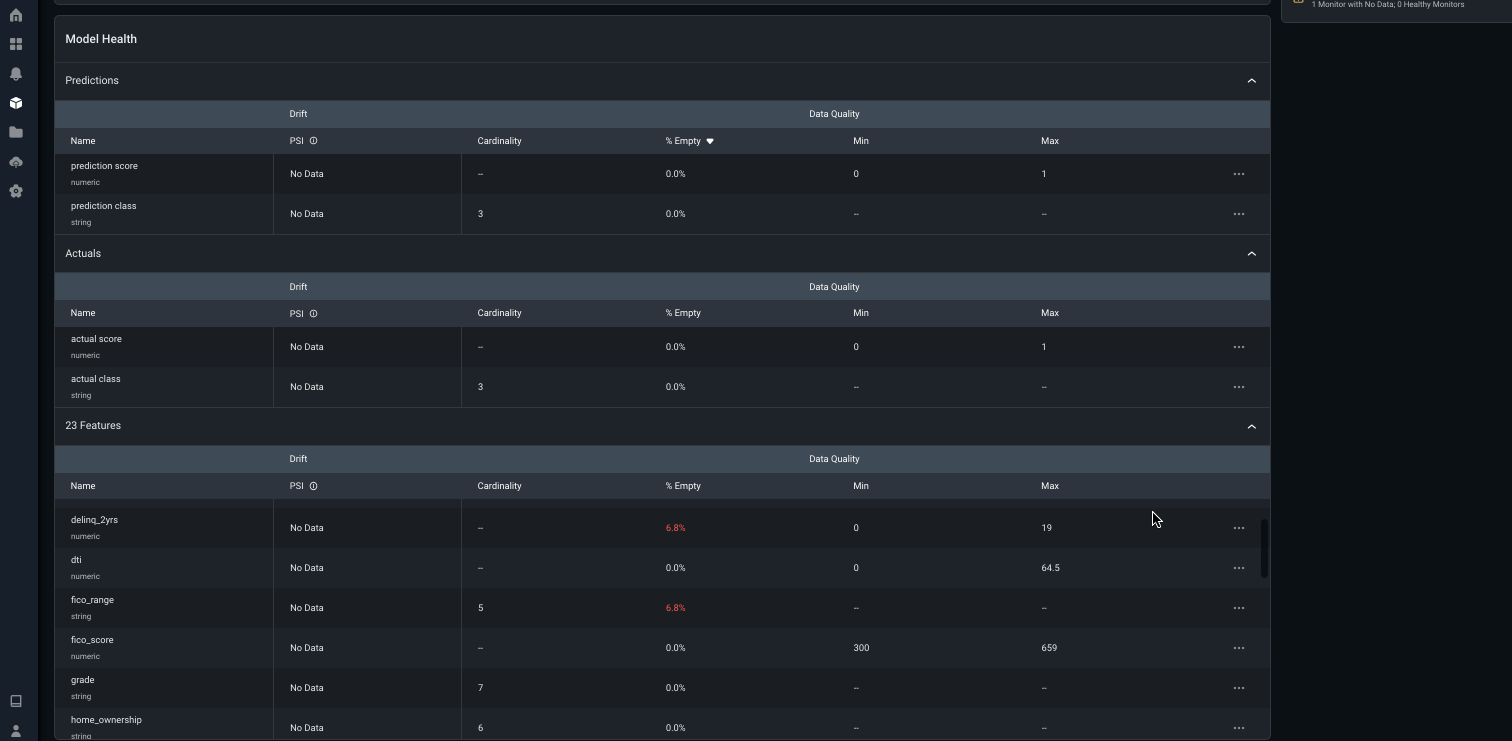

# Step 7. Performance Analysis

Model performance metrics measure how well your model performs in production. Once a performance monitor is triggered, navigate to the Performance tab to start troubleshooting your model issues and gain an understanding of what caused the degradation. 

**Compare production to training or other windows of production**. Bring in another dataset to compare performance and see which model performs better. This can help answer questions such as "Were we seeing this problem in training?" or "Does my new / previous model version perform better?". It can also be helpful to compare to other windows of production.

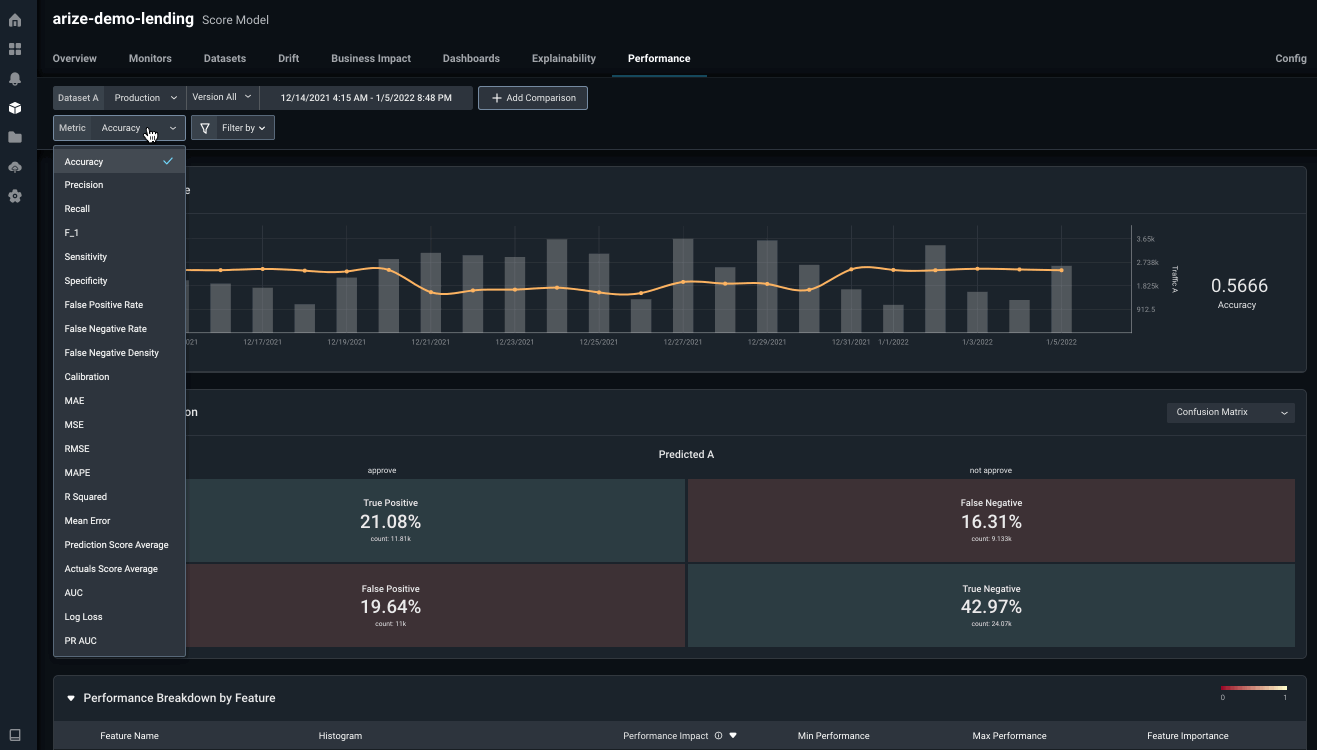


Identify low performing segments. By looking at performance breakdown by feature, you can dig even deeper to see which segment within each feature of the model is underperforming. 

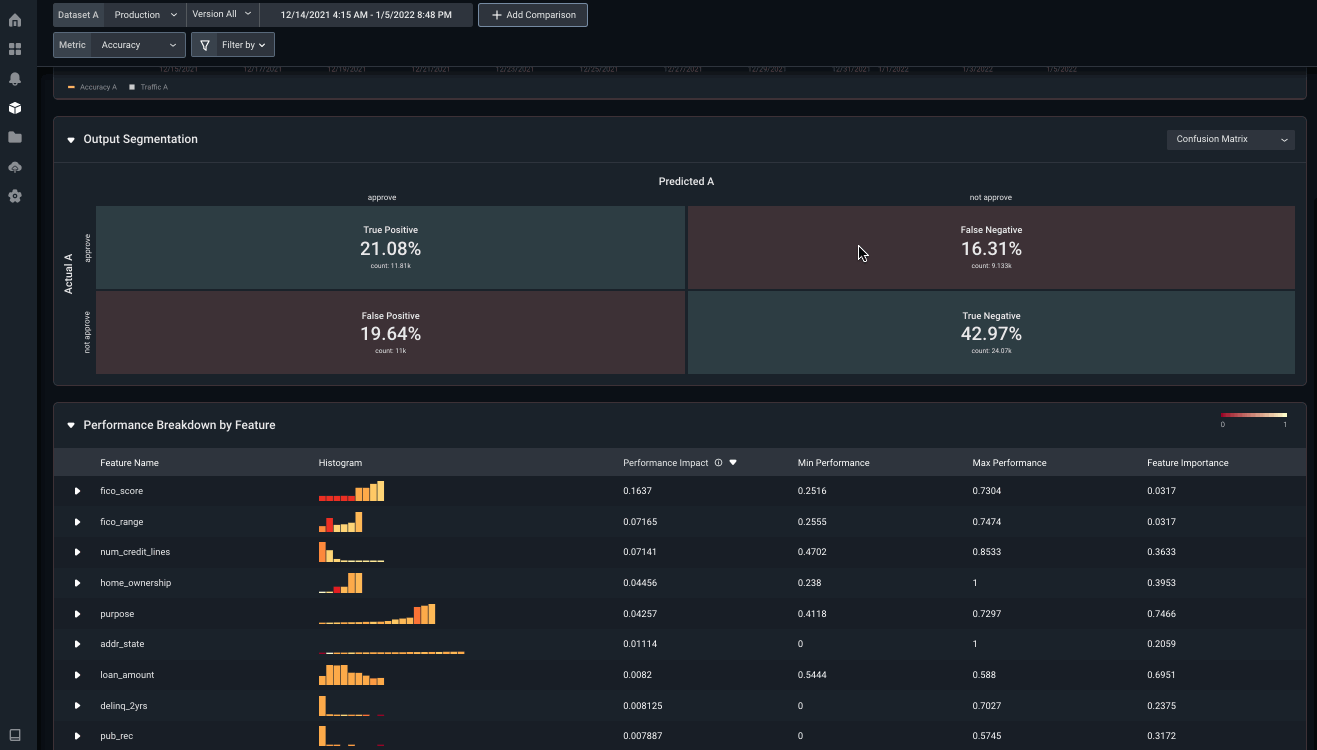

# Step 8. Model Performance Overview
As we continue to check in and improve our model's performance, we want to be able to quickly and efficiently view all our important model metrics in a single pane. In the same way we set up a **Model Performance Dashboard** to view our model's most important metrics in a single configurable layout. 

Navigate to the **Templates** section on the left sidebar and scroll down to click on the **Scored Model**. From there select your model, features you care to investigate, and positive class `deny`. 


![image](https://storage.googleapis.com/arize-assets/fixtures/Lending/lending_dashboard.gif)

In addition to the default widgets Arize sets up for your dashboard, you can configure custom metrics your team cares about. In only a few clicks you can add widgets to provide a single glance view of your model's **Accuracy**, **False Positive Rate**, and **False Negative Rate**. To visualize these metrics over time you can also create a custom timeseries widget which overlays three plots to showcase the fluctuation of these metrics over time.

![image](https://storage.googleapis.com/arize-assets/fixtures/Lending/lending_dashboard.png)

# Step 9. Business Impact

Sometimes, we need metrics other than traditional statistical measures to define model performance. [Business Impact](httphttps://app.gitbook.com/o/-MB4weB2E-qpBe07nmSL/s/-MAlgpMyBRcl2qFZRQ67/~/changes/P7XPzKa9hwZON38u42tR/product-guides/advanced/business-impacts://) is a way to measure your scored model's payoff at different thresholds (i.e, decision boundary for a scored model). 

Visualize the potential profit/loss based on these weighted decision values in Arize's **Business Impact** tab. Understand your business's overall profit/loss based on your model's prediction threshold for fraud classification.

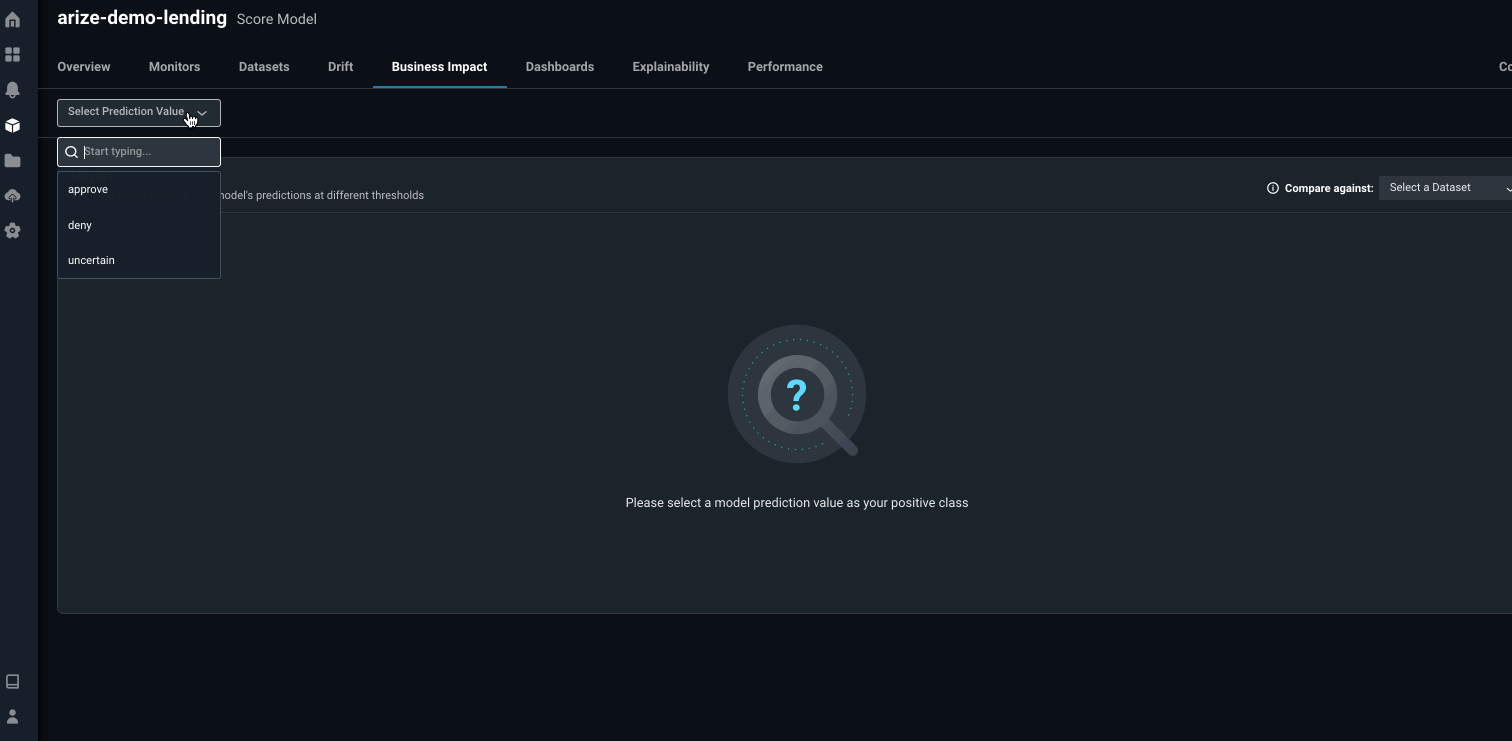


# Step 10. Explainability

Log feature importances to the Arize platform to explain your model's predictions. By logging these values, you gain the ability to view the global feature importances of your predictions as well as the ability to perform global and cohort prediction-based analysis to compare feature importances for your model's features.

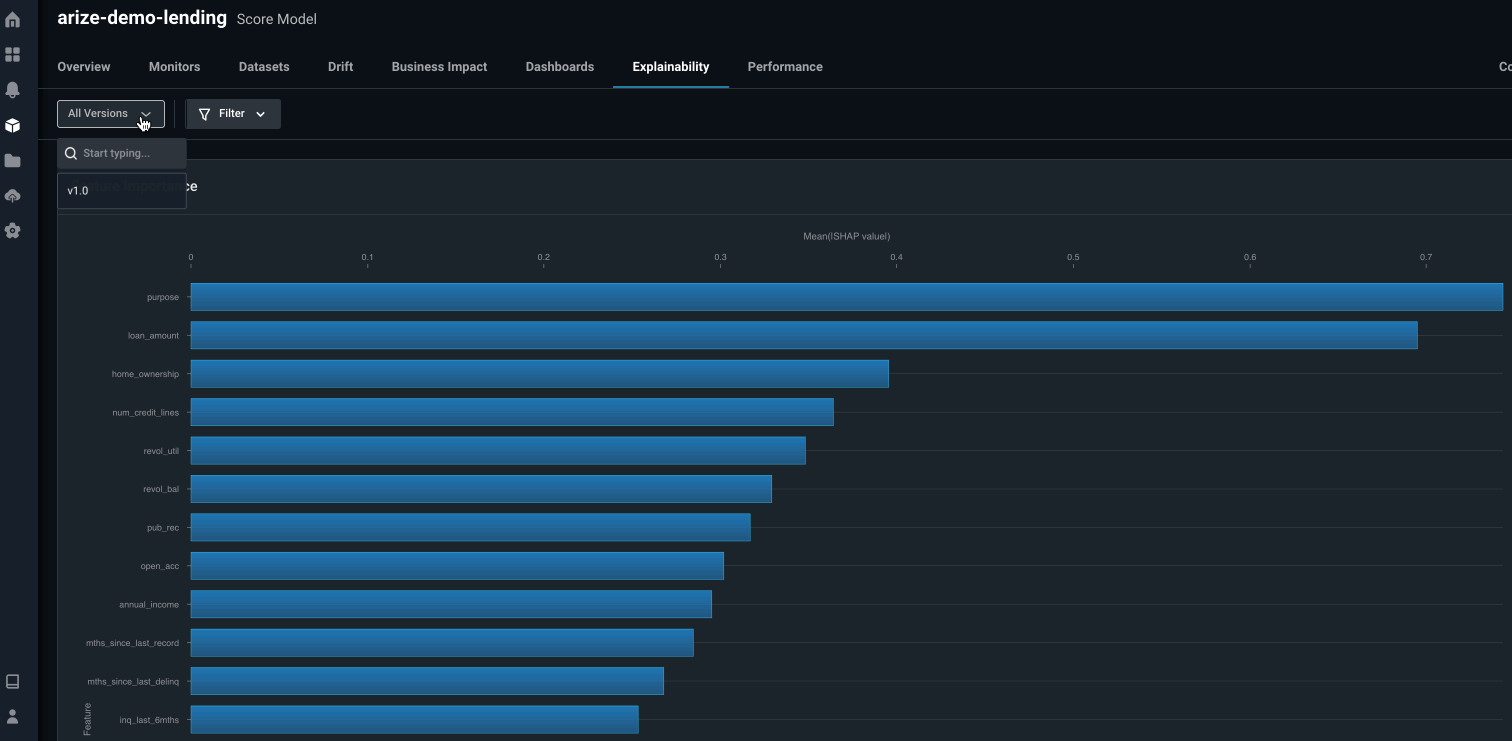


# Step 11. Resources

[On-Demand Webinar](https://arize.com/resource/webinar-ml-observability-lending/): Best Practices In ML Observability for Lending and Insurance featuring Richard Woolston, Data Science Manager at America First Credit Union. 


# 📚 Conclusion 
In this walkthrough we've shown how Arize can be used to log prediction data for a model, pinpoint model performance degradations, set up monitors to proactively catch future issues, create dashboards for at a glance model understanding, and calculate business impact metrics through custom formulas. 

We completed the following tasks: 
1. Uploaded data from a model predicting lending approval 
2. Set up a model baseline (Training v1.0) and managed Performance, Data Quality, and Drift monitors
3. Uncovered low performing segments of our population within the Performance tab of customers who have high `fico_score` and slow `num_credit_lines`.
4. Identified correlations between our model's degrading performance with individual feature drift and distribution variance. We uncovered that `credit_card` was a new input in the feature `purpose` that caused the model to drift. It could make sense to train the model on this input. 
5. Created a model Performance Overview Dashboard to visualize important metrics at a glance with custom timeseries metrics for ongoing analysis 
6. Captured our potential profit/loss based on our model's classification threshold using the Business Impact tab
7. Reviewed global and cohort explainability of our model

Though we covered a lot of ground, this is just scratching the surface of what the Arize platform can do. We urge you to explore more of Arize, either on your own or through one of our many other tutorials.


# About Arize
Arize is an end-to-end ML observability and model monitoring platform. The platform is designed to help ML engineers and data science practitioners surface and fix issues with ML models in production faster with:
- Automated ML monitoring and model monitoring
- Workflows to troubleshoot model performance
- Real-time visualizations for model performance monitoring, data quality monitoring, and drift monitoring
- Model prediction cohort analysis
- Pre-deployment model validation
- Integrated model explainability

### Website
Visit Us At: https://arize.com/model-monitoring/

### Additional Resources
- [What is ML observability?](https://arize.com/what-is-ml-observability/)
- [Playbook to model monitoring in production](https://arize.com/the-playbook-to-monitor-your-models-performance-in-production/)
- [Using statistical distance metrics for ML monitoring and observability](https://arize.com/using-statistical-distance-metrics-for-machine-learning-observability/)
- [ML infrastructure tools for data preparation](https://arize.com/ml-infrastructure-tools-for-data-preparation/)
- [ML infrastructure tools for model building](https://arize.com/ml-infrastructure-tools-for-model-building/)
- [ML infrastructure tools for production](https://arize.com/ml-infrastructure-tools-for-production-part-1/)
- [ML infrastructure tools for model deployment and model serving](https://arize.com/ml-infrastructure-tools-for-production-part-2-model-deployment-and-serving/)
- [ML infrastructure tools for ML monitoring and observability](https://arize.com/ml-infrastructure-tools-ml-observability/)

Visit the [Arize Blog](https://arize.com/blog) and [Resource Center](https://arize.com/resource-hub/) for more resources on ML observability and model monitoring.